In [13]:
import matplotlib.pyplot as plt
import numpy as np
import random

n_points = 100

xs = np.linspace(0, 1, n_points).reshape((-1, 1))
ys = xs + 0.5 * np.sin(xs * 15).reshape((-1, 1))

points = np.hstack([xs, ys])


Finde eine Menge von Liniensegmenten, sodass die Summe der quadratischen Abweichungen (Sum of squared errors) minimal ist.


Jede Linie verursacht fixe Kosten $c$ und wird durch den start und den Endpunkt eindeutig bestimmt

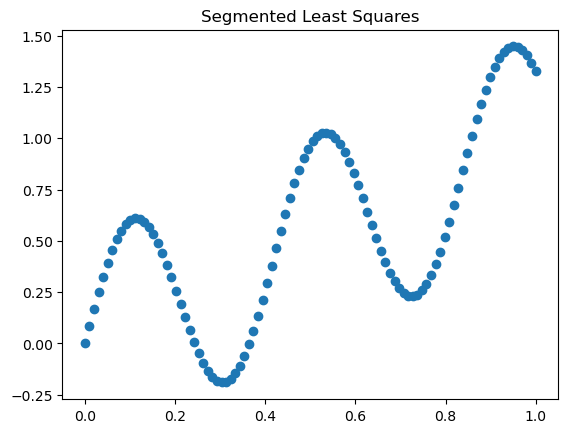

In [14]:
plt.title("Segmented Least Squares")
plt.scatter(points[:, 0], points[:, 1])
plt.show()

In [15]:
# Formel fuer lineare Regression wurde hier entnommen:
# https://www.varsitytutors.com/hotmath/hotmath_help/topics/line-of-best-fit
def get_line_params(points):
    
    xs = points[:, 0]
    ys = points[:, 1]
    
    x_mean = np.mean(xs, axis=0)
    y_mean = np.mean(ys, axis=0)
    
    # steigung der geraden
    m = np.dot((xs - x_mean), (ys - y_mean)) / np.dot((xs - x_mean), (xs - x_mean))
    c = y_mean - m * x_mean
    
    return m, c

In [16]:
def get_line_vals(points):
    
    m, c = get_line_params(points)
    
    min_x = np.min(points[:, 0])
    max_x = np.max(points[:, 0])
    
    xs = np.linspace(min_x, max_x, 1000).reshape((-1, 1))
    ys = m * xs + c
    
    line_vals = np.hstack([xs, ys])
    
    return line_vals

In [17]:
line_vals = get_line_vals(points)

Allein durch eine Menge von Punkten laesst sich die lineare Ausgleichsgerade eindeutig bestimmen.
"Finde eine Partition von Punkten" ist aequivalent zu "Finde eine Menge von Liniensegmenten", sodass die Kosten fuer die Geraden und die summe der quadratischen Abweichungen minimiert wird

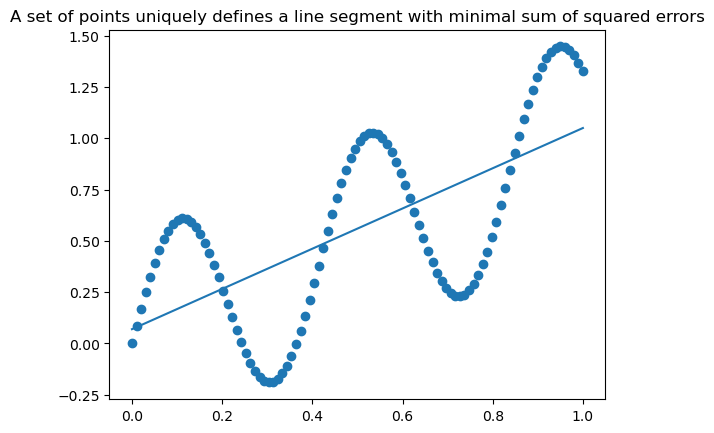

In [18]:
plt.title("A set of points uniquely defines a line segment with minimal sum of squared errors")
plt.scatter(points[:, 0], points[:, 1])
plt.plot(line_vals[:, 0], line_vals[:, 1])
plt.show()

In [102]:
def error_per_segment(points):
    
    # das wollen wir verhindern weil undefiniert
    if len(points) <= 1:
        return float("inf")
    
    m, c = get_line_params(points)
    
    # gib nur da, wo es einen x-wert gibt eine prediction ab
    
    xs = points[:, 0].reshape((-1, 1))
    ys = points[:, 1].reshape((-1, 1))
    pred = m * xs + c

    return np.sum(np.power(pred - ys, 2))

In [103]:
print(f"Fitting a line segment (optimally) to the entire set of points produces a cost of {error_per_segment(points)}.")

Fitting a line segment (optimally) to the entire set of points produces a cost of 12.473825255785641.


Man kann den Fehler reduzieren, indem man mehrere segmente auf unterschiedlichen streckenabschnitten einfuehrt, aber das kann zu "Overfitting" fuehren (es gibt ja noch keine Kosten pro Segment also koennte man alle punkte ueber liniensegmente miteinander verbinden

In [114]:
def segmented_least_squares(points, cost_per_segment):

    n = len(points)
    
    # die punkte sind 0-indexiert
    # mem speichert die kosten fuer die punkte (also mem[0] sagt wie viele kosten wenn man nur ersten punkt mitnimmt)
    mem = [0] * n
    
    # edge case : wenn es nur einen punkt gibt sollen die kosten 0 sein
    mem[0] = float("inf")
    
    # in welchem segment ist der letzte punkt
    # wir fangen beim zweiten an
    for j in range(1, n):
        
        opt_value = float("inf")
        
        # der punkt j ist mit allen punkten p_i, ... p_j in einem segment
        # i kann nicht j erreichen, sonst wuerde es bedeuten, dass wir gucken, ob j alleine sein kann
        for i in range(j):
            
            prev_optimal = mem[i-1] if i > 0 else 0
            
            new_cost = prev_optimal + error_per_segment(points[i:j+1]) + cost_per_segment
        
            if new_cost < opt_value:
                opt_value = new_cost
        
        mem[j] = opt_value
        
    return mem

In [122]:
def get_partition(points, mem, cost_per_segment):
    
    curr = len(points) - 1
    
    partition = []
    
    while curr > 0:
        
        opt_value = float("inf")
        opt_split_index = -1
        # how many points are in the segment that curr (the last point) is in?
        # i kann nicht nur mit sich selbst in einem segment sein
        for i in range(curr-1, -1, -1):
            
            prev_val = mem[i-1] if i > 0 else 0
            new_cost = prev_val + error_per_segment(points[i : curr+1]) + cost_per_segment
            
            if new_cost < opt_value:
                opt_value = new_cost
                opt_split_index = i
            
        partition.insert(0, points[opt_split_index : curr + 1])
        curr = opt_split_index - 1
        
    return partition

In [123]:
def get_set_of_points(point_arr):
    
    set_of_points = set()
    
    for i in range(len(point_arr)):
        x, y = point_arr[i]
        set_of_points.add((x, y))
        
    return  set_of_points

In [124]:
import itertools

def is_partition_valid(points, partition):
    
    indices_of_sets = range(len(partition))
    
    # all sets have to be disjoint
    for i, j in itertools.combinations(indices_of_sets, 2):
        
        set_a = get_set_of_points(partition[i])
        set_b = get_set_of_points(partition[j])
        
        if not set_a.isdisjoint(set_b):
            print("Not disjoint")
            return False
        
    # the union of all sets has to cover points
    point_set = get_set_of_points(points)
    union_set = set()
    
    for subset in partition:
        
        # this only holds true for our case
        if len(subset) < 2:
            print("Points are alone")
            return False

        union_set = union_set.union(get_set_of_points(subset))
    
    sets_equal = union_set.issubset(point_set) and point_set.issubset(union_set)
    
    if not sets_equal:
        print("Sets not equal")
        print("Missing ", point_set - union_set)
        return False
    
    return True

In [129]:
def draw_partition(points, partition, title):
    
    plt.title(title)
    plt.plot(points[:, 0], points[:, 1])
    
    for set_of_points in partition:
        line_vals = get_line_vals(set_of_points)
        plt.plot(line_vals[:, 0], line_vals[:, 1])
        
    plt.show()

In [131]:
def segment_and_draw(points, cost_per_segment):

    mem = segmented_least_squares(points, cost_per_segment)

    partition = get_partition(points, mem, cost_per_segment)

    assert(is_partition_valid(points, partition))

    draw_partition(points, partition, title=f"Cost per segment = {cost_per_segment}")

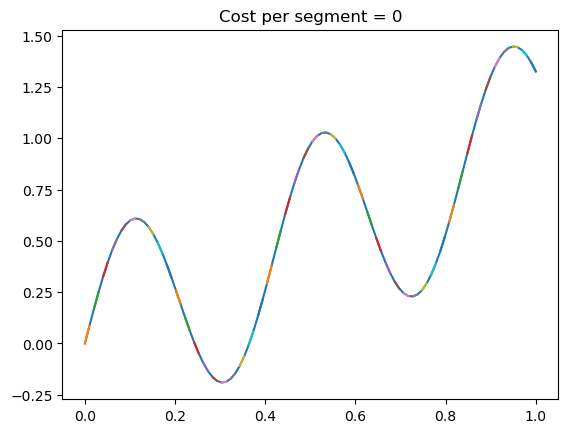

In [132]:
segment_and_draw(points, 0)

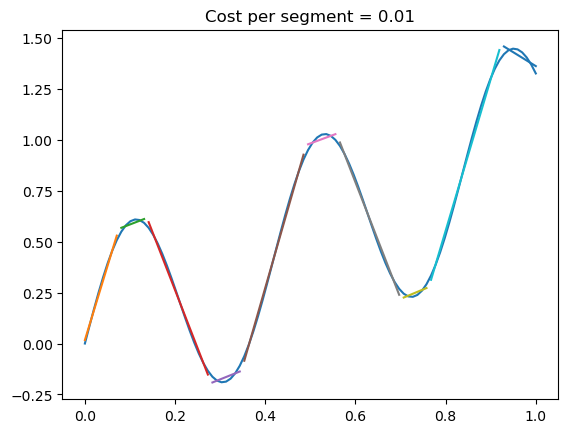

In [137]:
segment_and_draw(points, 0.01)

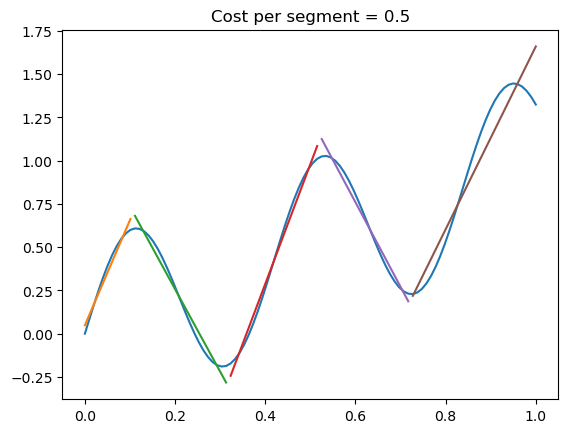

In [138]:
segment_and_draw(points, 0.5)

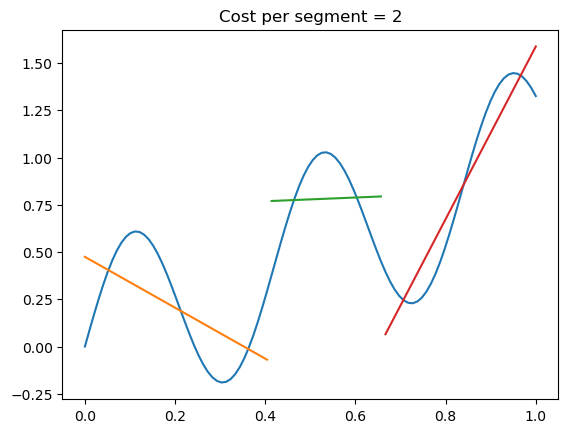

In [140]:
segment_and_draw(points, 2)

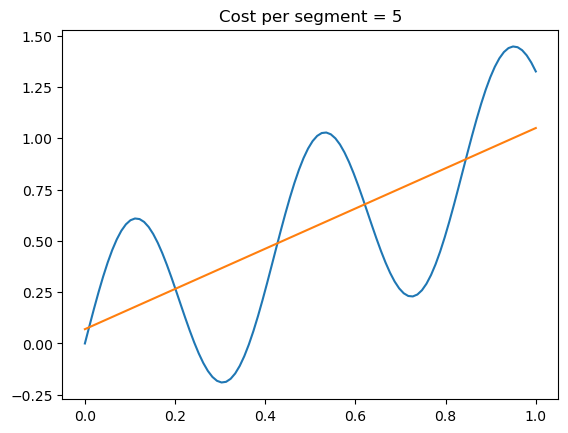

In [142]:
segment_and_draw(points, 5)